# Testis Replicate 1 scRNA-Seq UMI Cutoff 2,000

This is the seurat analysis for testis replicate 1 after setting the UMI cuotff of 2,000

In [3]:
options(repr.plot.width=10, repr.plot.height=10)

In [5]:
DATA_DIR <- '../output/testis1/outs/filtered_gene_bc_matrices/dm6.16'
DATA <- '../output/2018-03-21_explore_umi_testis1_2000.tsv'
OUTDIR <- '../output/testis1_scRNAseq_umi_2k'
REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')
NAME <- 'TestisForce3k'

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [33]:
source('../lib/seurat.R')

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [11]:
dat <- read.table(DATA, header=TRUE)

In [13]:
# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes
sobj <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes = 200, project = NAME)
nCells <- dim(sobj@meta.data)[1]

# calculate the percent genes on chrom M
mask <- row.names(sobj@raw.data) %in% mito
percent.mito <- Matrix::colSums(sobj@raw.data[mask, ]/Matrix::colSums(sobj@raw.data)) * 100
sobj <- AddMetaData(object = sobj, metadata = percent.mito, col.name = "percent_mito")

In [14]:
nCells

[1] 1503

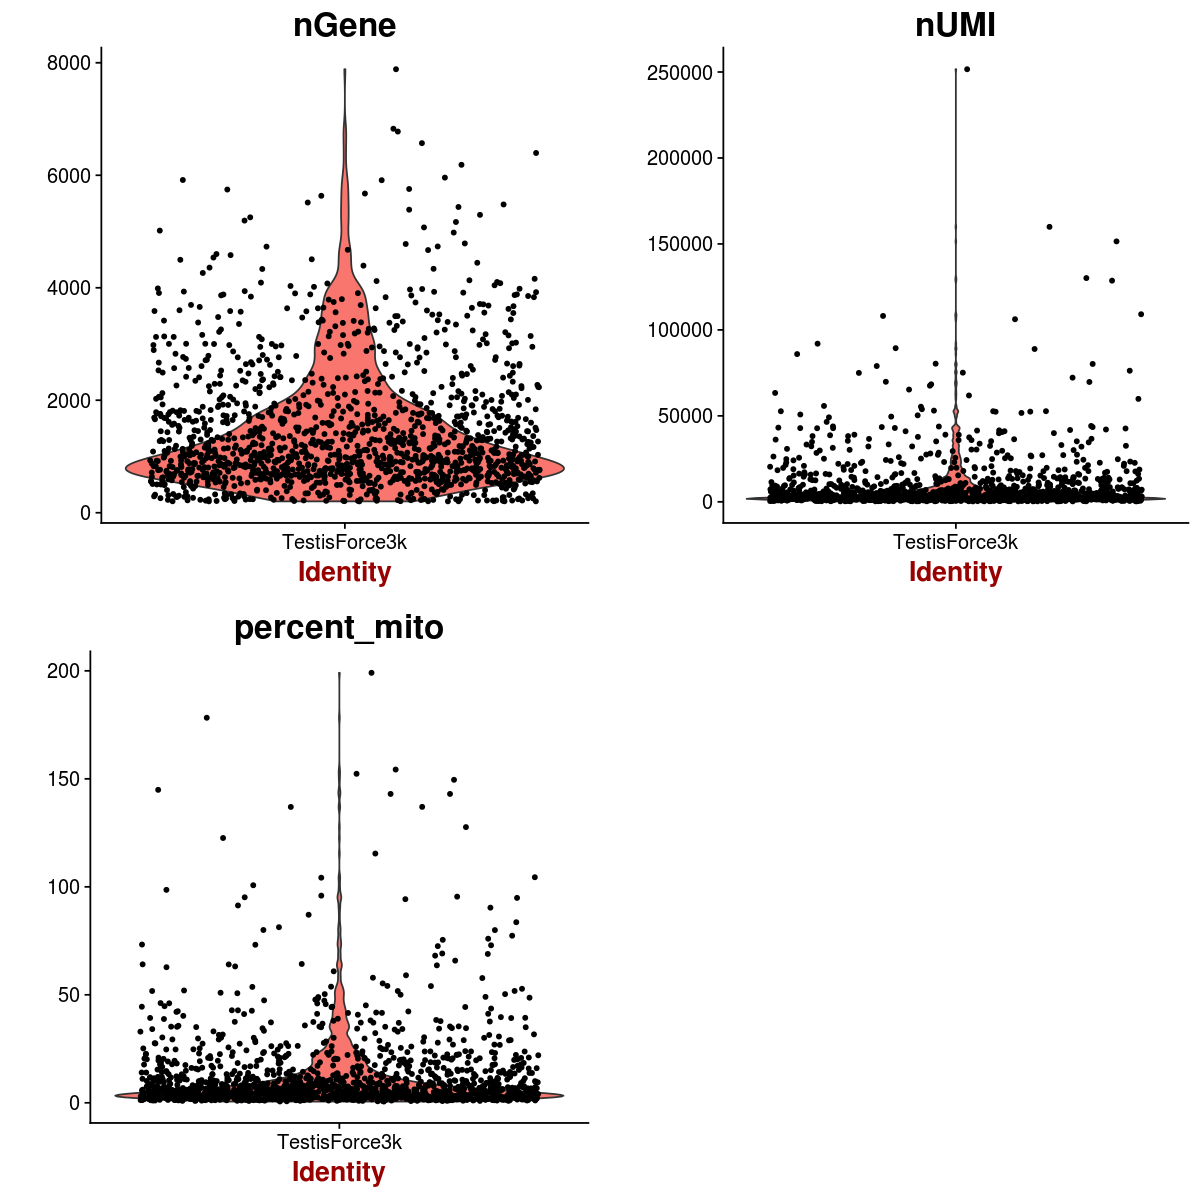

In [15]:
VlnPlot(object = sobj, features.plot = c('nGene', 'nUMI', 'percent_mito'), nCol = 2)

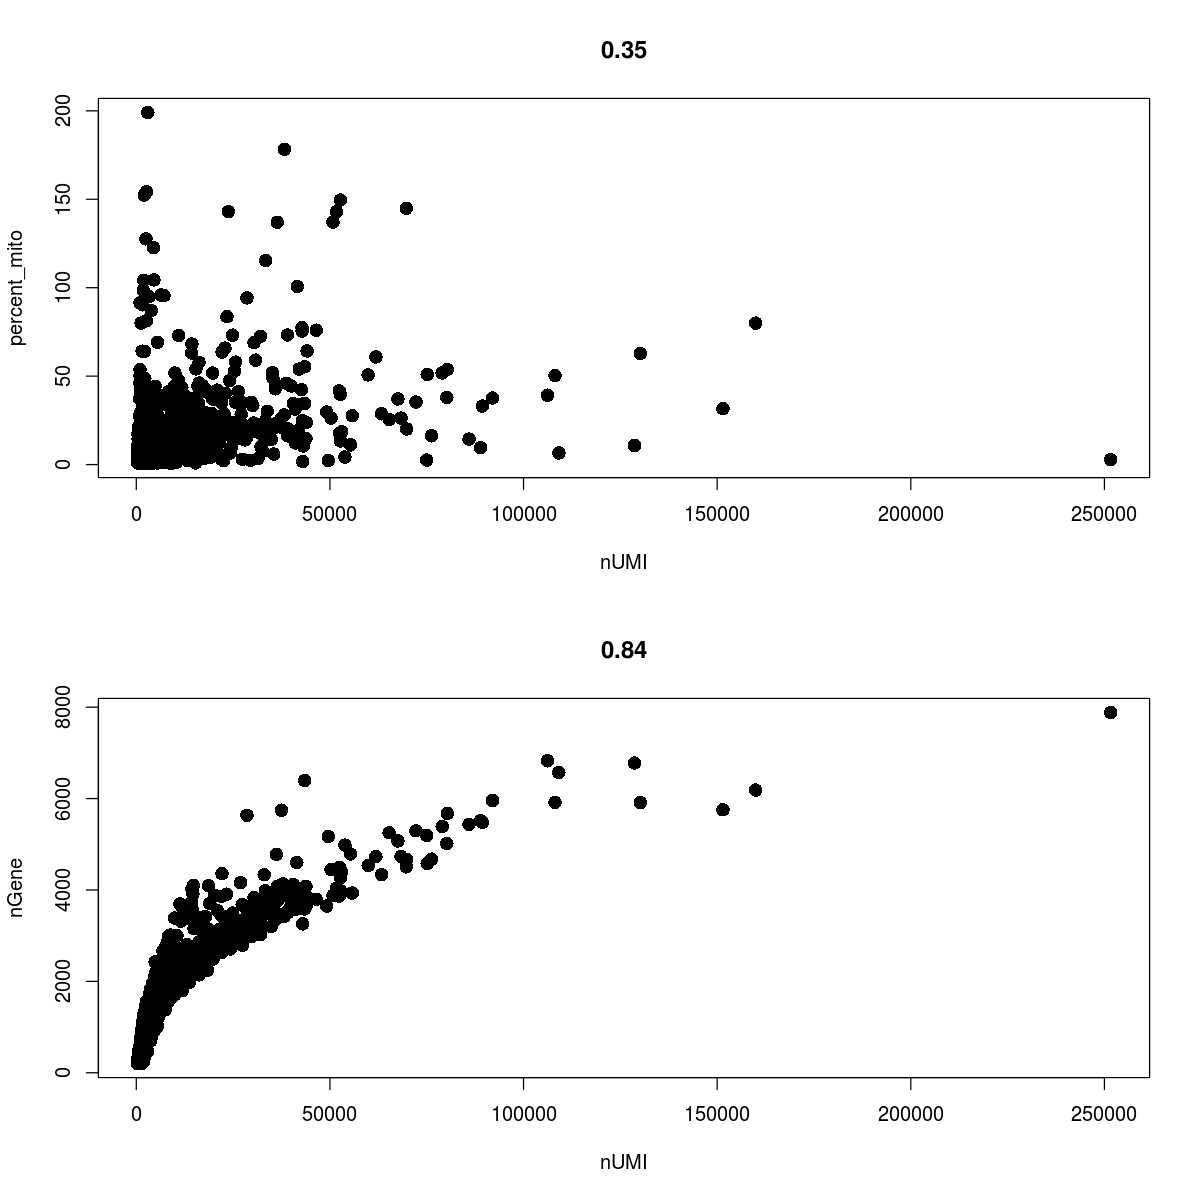

In [16]:
par(mfrow = c(2, 1))
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'percent_mito')
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'nGene')

In [17]:
# Filter Genes based on low and high gene counts
sobj <- FilterCells(object=sobj, subset.names=c("nGene"), low.thresholds=c(200), high.thresholds=c(6000))

In [19]:
dim(sobj@meta.data)[1]

[1] 1497

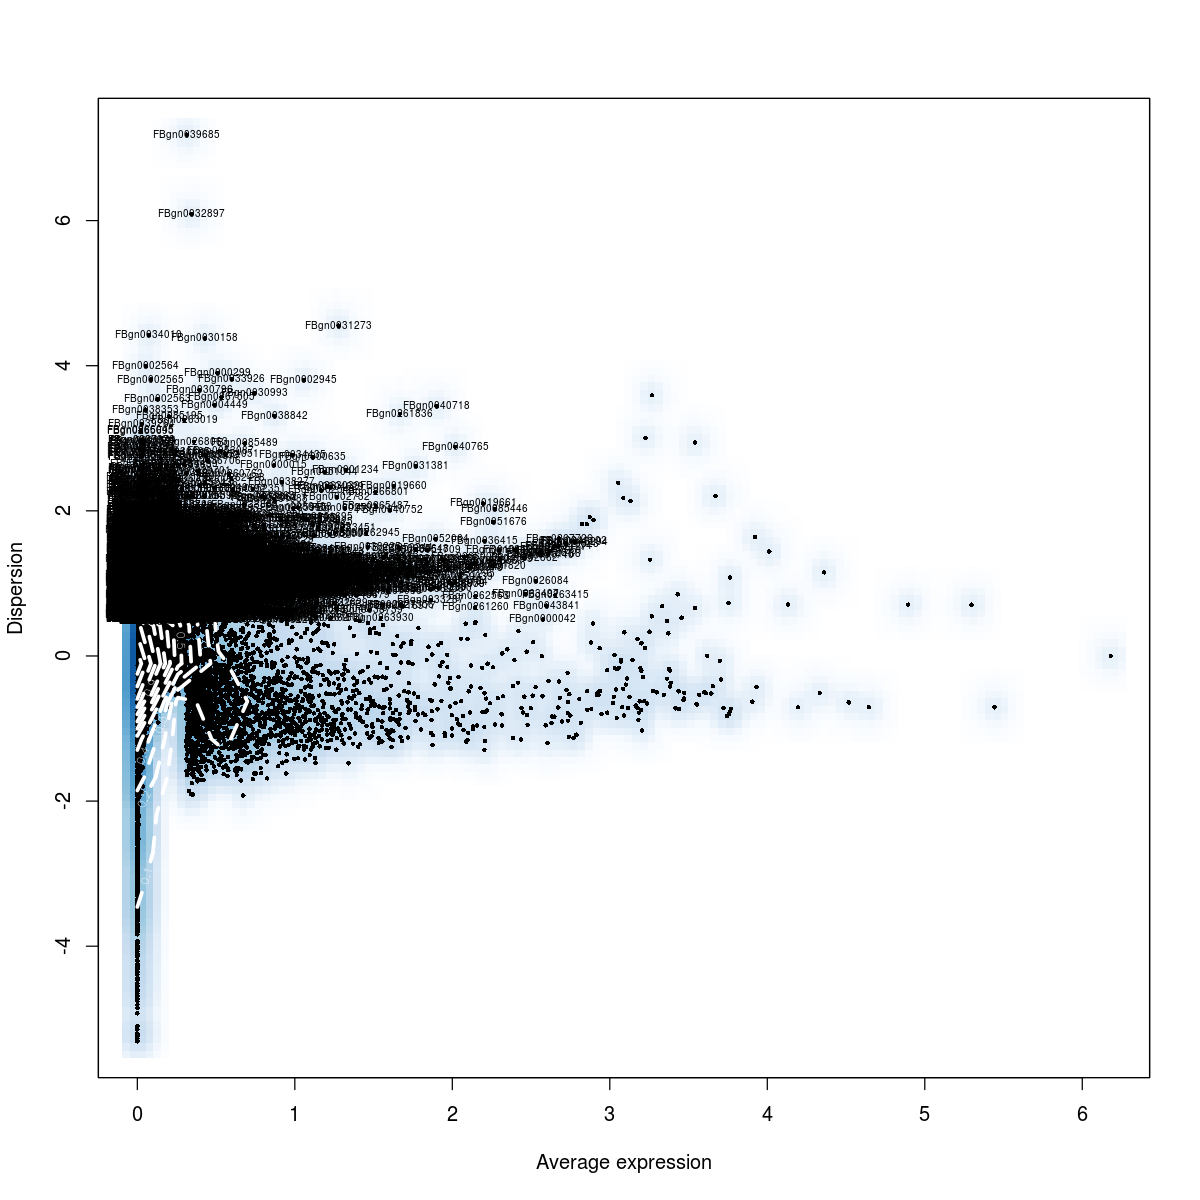

In [20]:
sobj <- NormalizeData(object = sobj, normalization.method = "LogNormalize", scale.factor = 1e4)
sobj <- FindVariableGenes(object = sobj, mean.function = ExpMean, dispersion.function = LogVMR,
                           x.low.cutoff = 0.01, 
                           x.high.cutoff = 2.8, 
                           y.cutoff = 0.5,
                           y.high.cutoff = Inf
                          )

In [21]:
length(x = sobj@var.genes)

[1] 3269

In [22]:
sobj <- ScaleData(object = sobj, vars.to.regress = c("nUMI"), display.progress = F)

In [23]:
### Perform linear dimensional reduction
sobj <- RunPCA(object = sobj, pc.genes = sobj@var.genes, do.print = FALSE, pcs.print = 1:5, genes.print = 5, pcs.compute = 100)

In [24]:
PrintPCA(object = sobj, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

[1] "PC1"
[1] "FBgn0000042" "FBgn0261260" "FBgn0026084" "FBgn0003165" "FBgn0010113"
[1] ""
[1] "FBgn0036415" "FBgn0265648" "FBgn0051709" "FBgn0046297" "FBgn0032588"
[1] ""
[1] ""
[1] "PC2"
[1] "FBgn0265487" "FBgn0016977" "FBgn0010113" "FBgn0001316" "FBgn0002543"
[1] ""
[1] "FBgn0043841" "FBgn0263415" "FBgn0063497" "FBgn0262563" "FBgn0027556"
[1] ""
[1] ""
[1] "PC3"
[1] "FBgn0283451" "FBgn0002543" "FBgn0013733" "FBgn0019660" "FBgn0026160"
[1] ""
[1] "FBgn0031296" "FBgn0262104" "FBgn0283442" "FBgn0034822" "FBgn0032089"
[1] ""
[1] ""
[1] "PC4"
[1] "FBgn0000299" "FBgn0030993" "FBgn0036821" "FBgn0268063" "FBgn0030796"
[1] ""
[1] "FBgn0004795" "FBgn0000015" "FBgn0086408" "FBgn0259244" "FBgn0266801"
[1] ""
[1] ""
[1] "PC5"
[1] "FBgn0028669" "FBgn0264307" "FBgn0011244" "FBgn0052436" "FBgn0035724"
[1] ""
[1] "FBgn0030993" "FBgn0000299" "FBgn0268063" "FBgn0030796" "FBgn0036821"
[1] ""
[1] ""


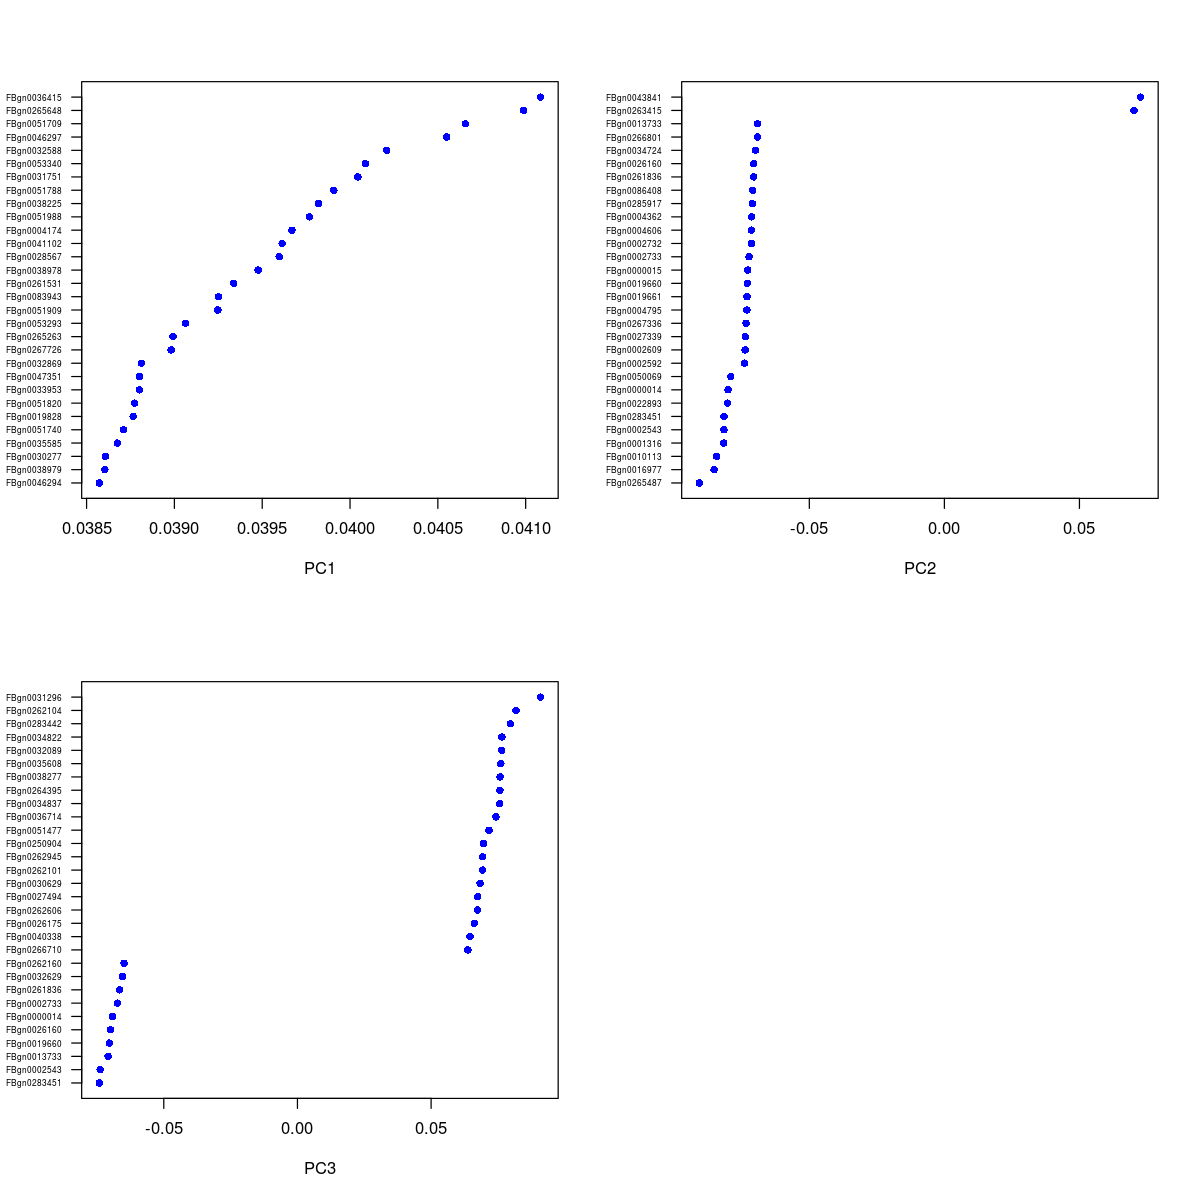

In [25]:
VizPCA(object = sobj, pcs.use = 1:3)

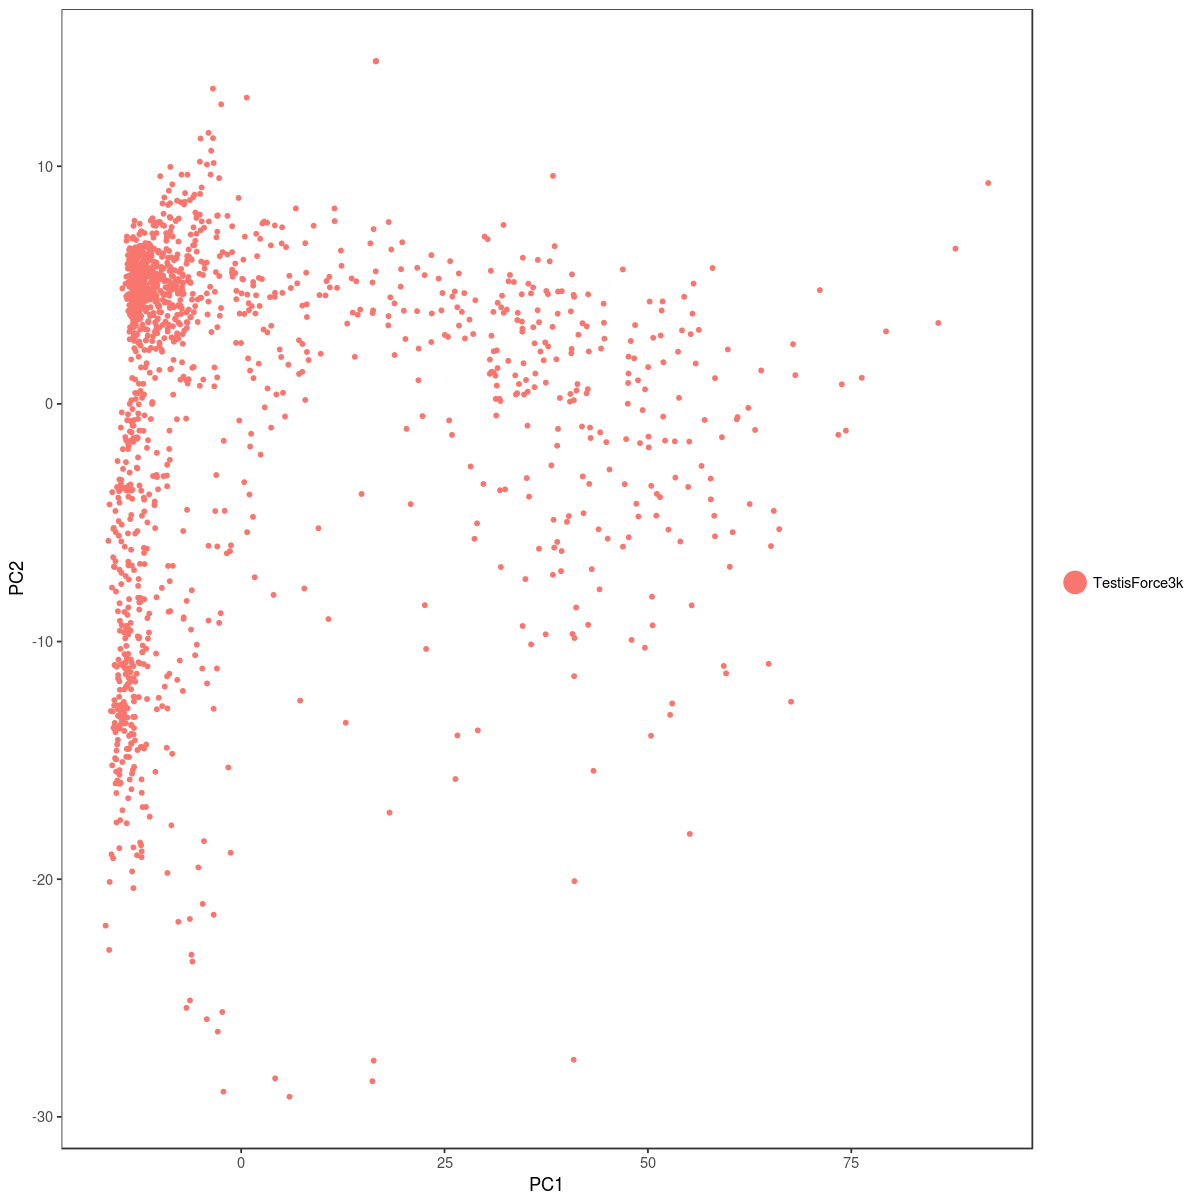

In [26]:
PCAPlot(object = sobj, dim.1 = 1, dim.2 = 2)

In [27]:
# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
sobj <- ProjectPCA(object = sobj, do.print = F)

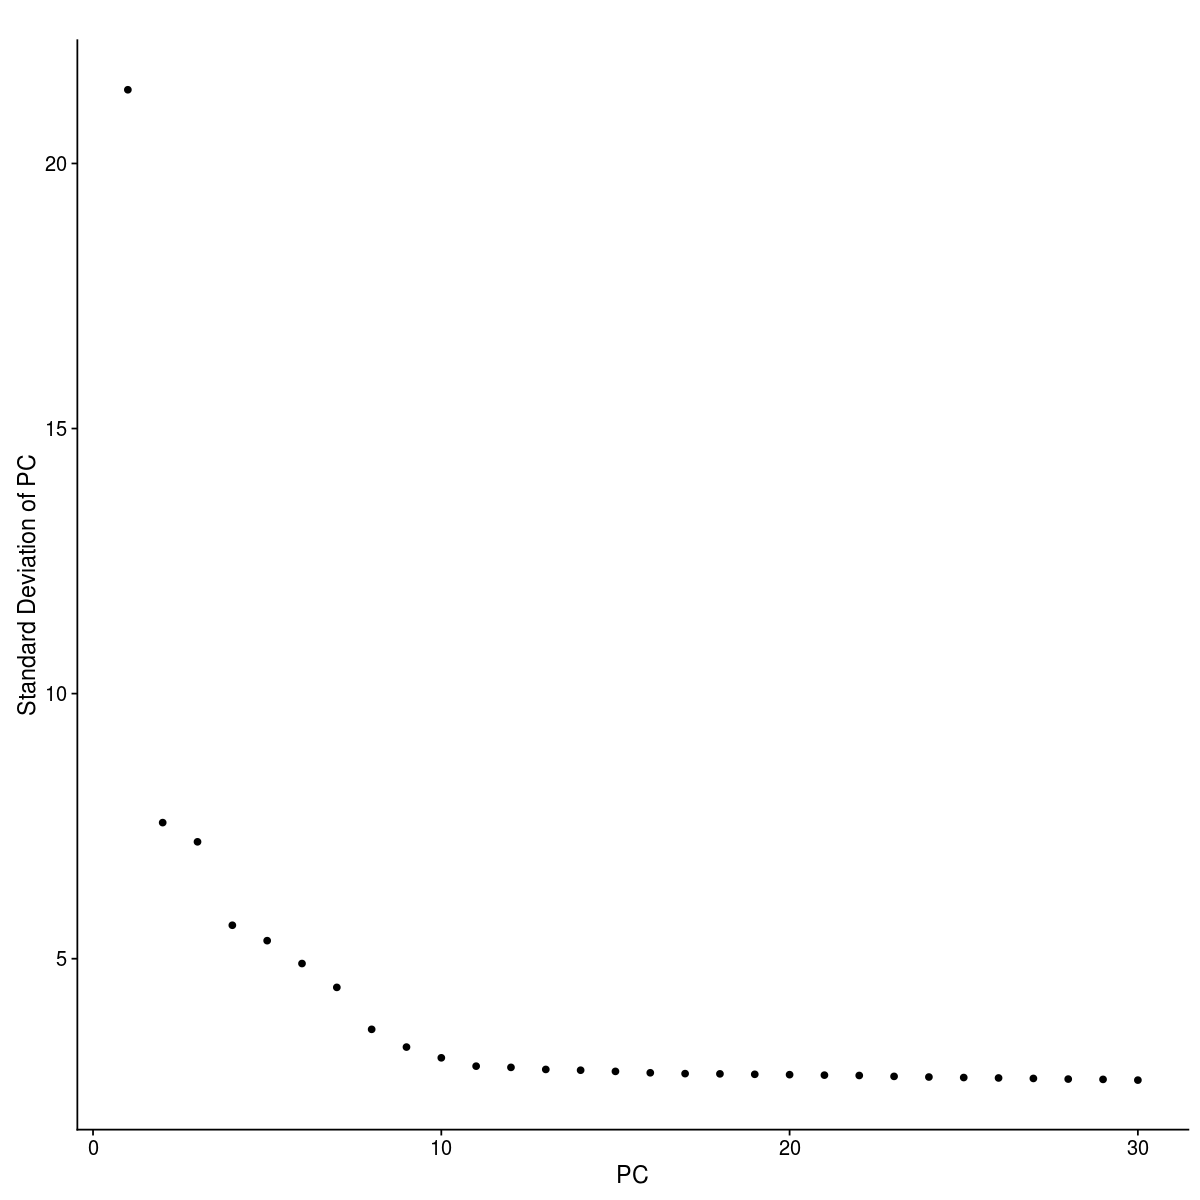

In [28]:
PCElbowPlot(object = sobj, num.pc=30)

In [39]:
sobj <- JackStraw(object = sobj, num.replicate = 100, do.print = FALSE, num.pc = 30)

Warning message:
“Removed 76079 rows containing missing values (geom_point).”

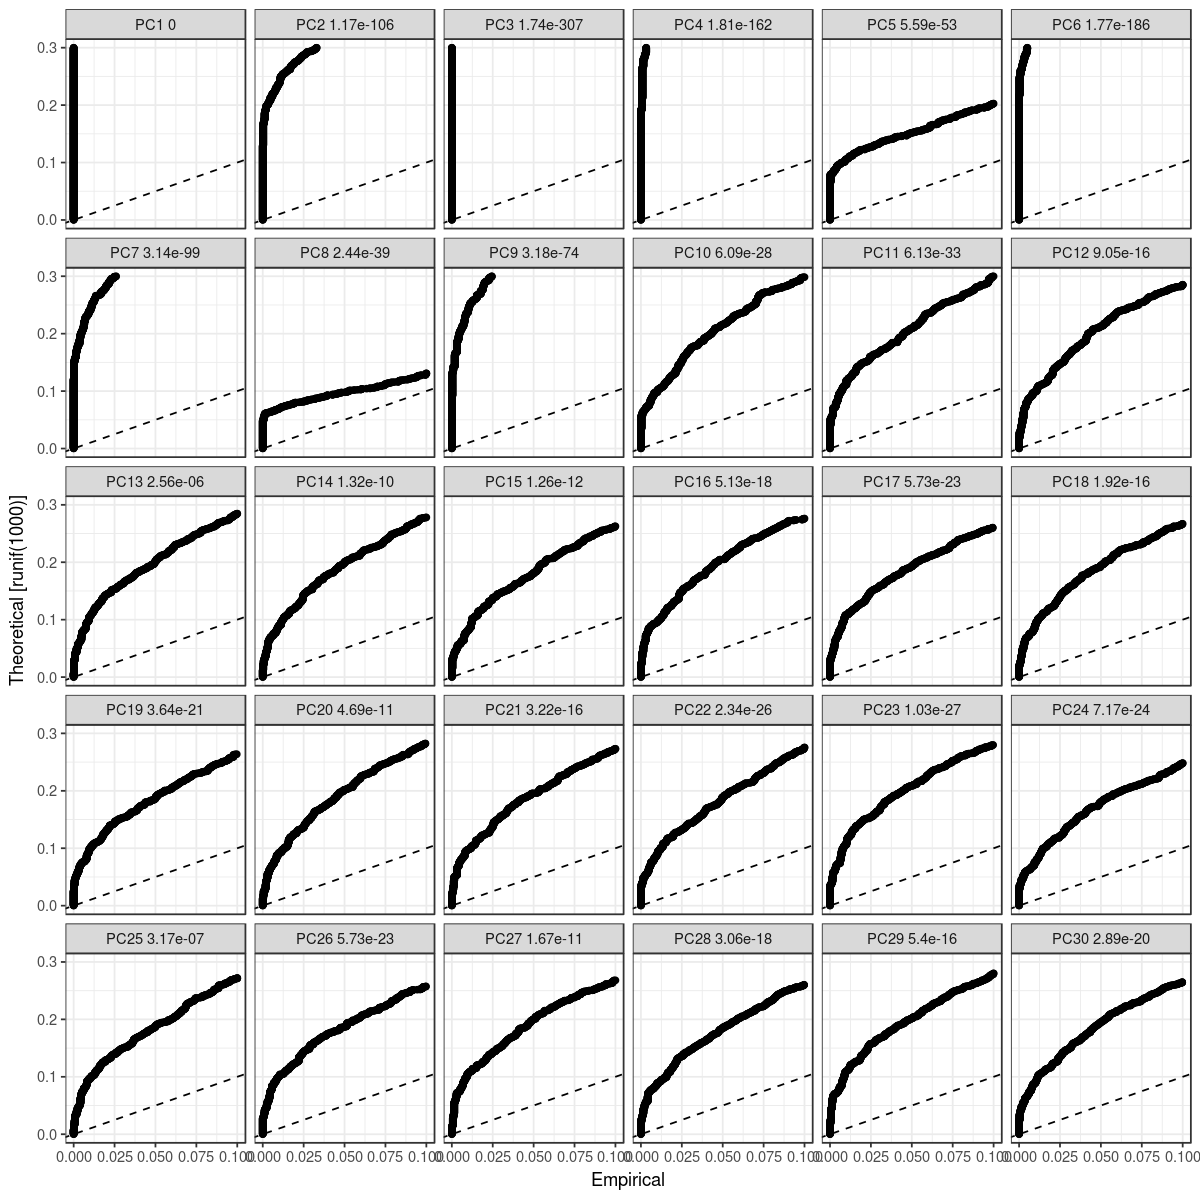

In [40]:
JackStrawPlot(object = sobj, nCol = 6, PCs = 1:30)

In [29]:
sobj <- FindClusters(
    object = sobj, 
    reduction.type = "pca", 
    dims.use = 1:30, 
    resolution = c(0.4, 0.6, 1.0, 1.2, 1.4),
    print.output = 0, 
    save.SNN = TRUE, 
)
PrintFindClustersParams(object = sobj)

Parameters used in latest FindClusters calculation run on: 2018-03-21 18:36:55
Resolution: 0.4
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30



In [30]:
### Run Non-linear dimensional reduction (tSNE)
sobj <- RunTSNE(object = sobj, dims.use = 1:30, do.fast = TRUE)

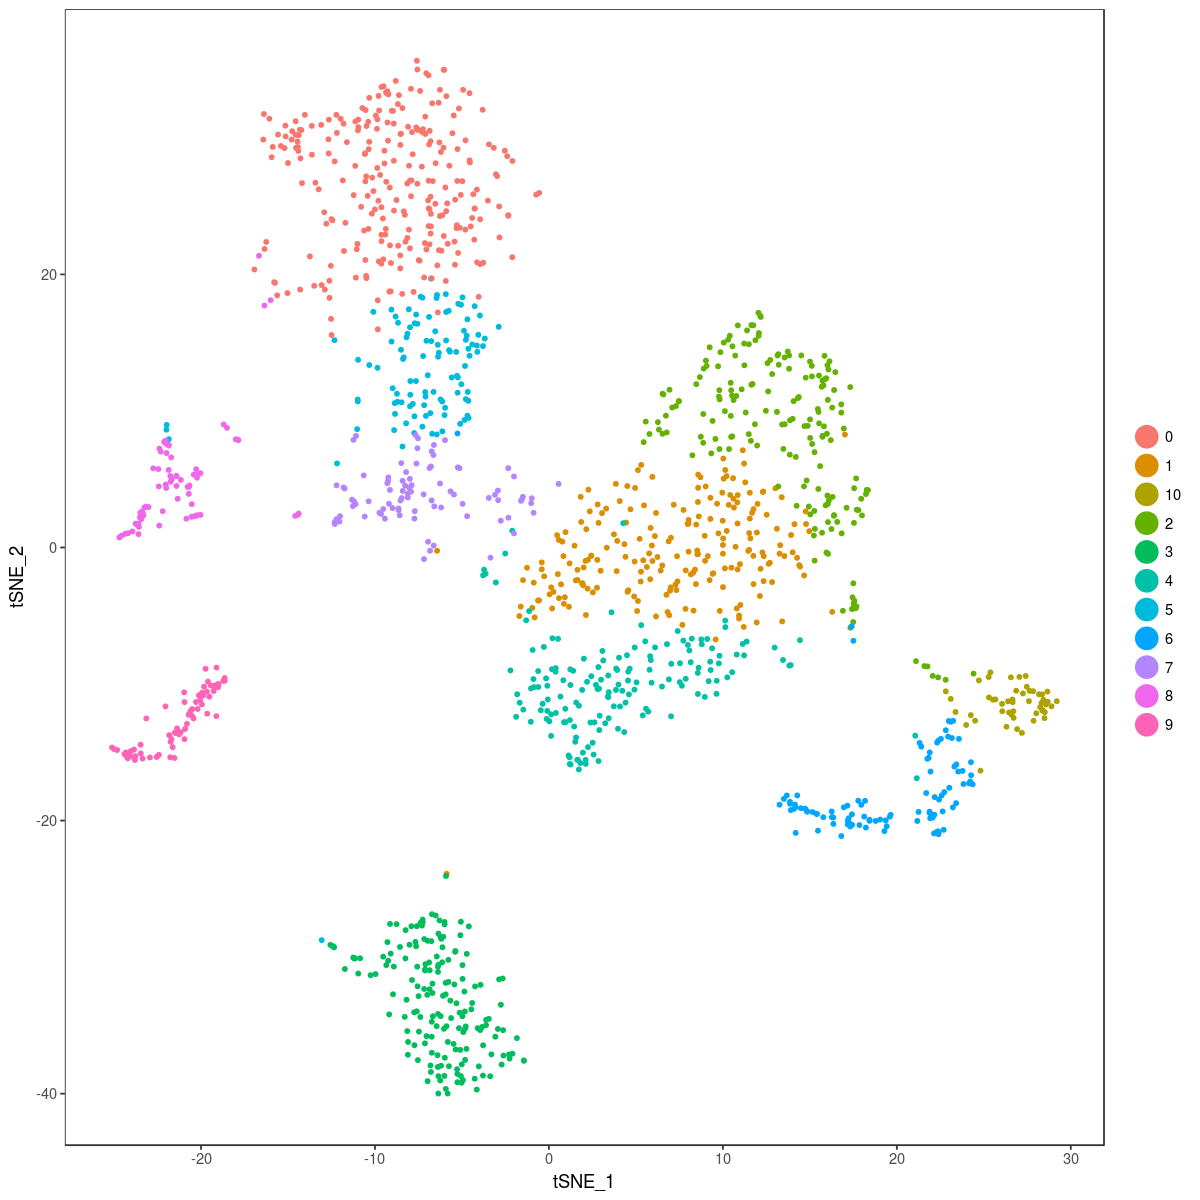

In [31]:
TSNEPlot(object = sobj, group.by='res.1.2')

In [34]:
dump_seurat(object = sobj, dir = OUTDIR)

In [ ]:
# Save cluster info
params <- c(0.4, 0.6, 1.0, 1.2, 1.4)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    sobj <- SetAllIdent(sobj, id = name)
    markers <- FindAllMarkers(object = sobj, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR, fname = fname)
}